# Webscraping with BeautifulSoup
[Source](https://www.peerlyst.com/posts/python-webscraping-anaconda-beautifulsoup-jupyter-and-the-hhs-wall-of-shame-molly-payne)

Additional References
* https://css-tricks.com/how-css-selectors-work/
* https://scrapy.org/
* https://www.seleniumhq.org/
* https://automatetheboringstuff.com/chapter11/

Lets Scrape the wall of shame from the U.S. Department of Health and Human Services
Office for Civil Rights (You could just download the data file, but where is the fun in that!)

## Step 1 - Import all of the libraries you'll need
1. requests
2. pandas
3. numpy
4. matplotlib.pyplot
5. Beautiful Soup

In [1]:
import requests, pandas, numpy, matplotlib.pyplot
from bs4 import BeautifulSoup

## Step 2 - Download the data

### 2.a Use the requests library to grab the content of this page 

<https://ocrportal.hhs.gov/ocr/breach/breach_report.jsf>

In [2]:
page = requests.get("https://ocrportal.hhs.gov/ocr/breach/breach_report.jsf")

In [3]:
page.content.decode('utf-8')[:1000]

'<!DOCTYPE html>\n<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en" dir="ltr"><head id="j_idt2">\n\t\t\t<meta http-equiv="X-UA-Compatible" content="IE=9" /><link type="text/css" rel="stylesheet" href="/ocr/javax.faces.resource/theme.css.jsf?ln=primefaces-aristo" /><link type="text/css" rel="stylesheet" href="/ocr/javax.faces.resource/components.css.jsf;jsessionid=EA495EBBA68EF5DB762BB7F9A1D88BEE?ln=primefaces&amp;v=6.1" /><script type="text/javascript" src="/ocr/javax.faces.resource/jquery/jquery.js.jsf;jsessionid=EA495EBBA68EF5DB762BB7F9A1D88BEE?ln=primefaces&amp;v=6.1"></script><script type="text/javascript" src="/ocr/javax.faces.resource/jquery/jquery-plugins.js.jsf;jsessionid=EA495EBBA68EF5DB762BB7F9A1D88BEE?ln=primefaces&amp;v=6.1"></script><script type="text/javascript" src="/ocr/javax.faces.resource/core.js.jsf;jsessionid=EA495EBBA68EF5DB762BB7F9A1D88BEE?ln=primefaces&amp;v=6.1"></script><script type="text/javascript" src="/ocr/javax.faces.resource/components.js

### 2.b Check thte status code of the page and print it to the screen

In [4]:
page.status_code

200

# Step 3 - BeautifulSoup

### 3.a Load the page content into a BeautifulSoup object named soup

In [5]:
soup = BeautifulSoup(page.content, 'html.parser')

### 3.b Display the soup object to visually interrogate

In [6]:
print(type(soup), '\n', soup)

<class 'bs4.BeautifulSoup'> 
 <!DOCTYPE html>

<html dir="ltr" lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml"><head id="j_idt2">
<meta content="IE=9" http-equiv="X-UA-Compatible"/><link href="/ocr/javax.faces.resource/theme.css.jsf?ln=primefaces-aristo" rel="stylesheet" type="text/css"/><link href="/ocr/javax.faces.resource/components.css.jsf;jsessionid=EA495EBBA68EF5DB762BB7F9A1D88BEE?ln=primefaces&amp;v=6.1" rel="stylesheet" type="text/css"/><script src="/ocr/javax.faces.resource/jquery/jquery.js.jsf;jsessionid=EA495EBBA68EF5DB762BB7F9A1D88BEE?ln=primefaces&amp;v=6.1" type="text/javascript"></script><script src="/ocr/javax.faces.resource/jquery/jquery-plugins.js.jsf;jsessionid=EA495EBBA68EF5DB762BB7F9A1D88BEE?ln=primefaces&amp;v=6.1" type="text/javascript"></script><script src="/ocr/javax.faces.resource/core.js.jsf;jsessionid=EA495EBBA68EF5DB762BB7F9A1D88BEE?ln=primefaces&amp;v=6.1" type="text/javascript"></script><script src="/ocr/javax.faces.resource/components.js.jsf

# Step 4 - Parse the Breach data

After inspecting the page we found that ```<td role="gridcell">``` usually precedes the breach records.

### 4.a find the gridcells and store in a variable named 

```gridCell```

In [7]:
gridCells = soup.find_all(role="gridcell")

In [8]:
print(gridCells[:2])

[<td class="ui-panelgrid-cell" colspan="4" role="gridcell">As required by section 13402(e)(4) of the HITECH Act, the Secretary must post a list of breaches of unsecured protected health information affecting 500 or more individuals. The following breaches have been reported to the Secretary:
				<br/><br/><span style="font-size: 1.5em; font-weight: bold">Cases Currently Under Investigation</span></td>, <td class="ui-panelgrid-cell" colspan="4" role="gridcell">This page lists all breaches reported within the last 24 months that are currently under investigation by the Office for Civil Rights.</td>]


In [9]:
tr = soup.find_all('tr')

In [10]:
len(tr)

104

### 4.b display the gridCells to inspect

In [11]:
gridCells[0]

<td class="ui-panelgrid-cell" colspan="4" role="gridcell">As required by section 13402(e)(4) of the HITECH Act, the Secretary must post a list of breaches of unsecured protected health information affecting 500 or more individuals. The following breaches have been reported to the Secretary:
				<br/><br/><span style="font-size: 1.5em; font-weight: bold">Cases Currently Under Investigation</span></td>

In [12]:
gridCells[-1]

<td role="gridcell" style="display: none"><span style="white-space:pre-line;"></span></td>

We've decided that we want to store the contents of the breach data into lists named:

```
singleBreachList - contains the tokenized breach data from the web page
```

We'll use singleBreachList to construct the following lists

```
nameCoveredEntityList             - singleBreachList item 0
stateList                         - singleBreachList item 1
coveredEntityTypeList             - singleBreachList item 2
affectIndividualsList             - singleBreachList item 3
breachSubmittedDateList           - singleBreachList item 4
typeOfBreachList                  - singleBreachList item 5
locationOfBreachedInformationList - singleBreachList item 6

```

Also notice that not all of "gridcell" was breach data, we need to skip a couple lines to get to the good stuff. Use a counter to do this, specifically 

```
skipTheBoringStuffCounter
```

There also appears to be a pattern in how the gridcell data is organized, there is a new event every 8 lines. Use a counter for that as well, specifically 

```
theGoodStuffCounter
```

### 4.c Initialize all of the lists to empty lists and the counters to zero.

In [13]:
nameCoveredEntityList = []
stateList = []
coveredEntityTypeList = []
affectIndividualsList = []
breachSubmittedDateList = []
typeOfBreachList = []
locationOfBreachedInformationList = []
singleBreachList = []
skipTheBoringStuffCounter = 0
theGoodStuffCounter = 0

### 4.d Parse the Data

In [14]:
for c in gridCells:
    if skipTheBoringStuffCounter <= 4:
        skipTheBoringStuffCounter = skipTheBoringStuffCounter + 1

    if skipTheBoringStuffCounter > 4:
        c = c.get_text().strip()
        
        if c != '':
            singleBreachList.append(c)
            theGoodStuffCounter = theGoodStuffCounter + 1

            if theGoodStuffCounter == 8:
                nameCoveredEntityList.append(singleBreachList[0])
                stateList.append(singleBreachList[1])
                coveredEntityTypeList.append(singleBreachList[2])
                affectIndividualsList.append(singleBreachList[3])
                breachSubmittedDateList.append(singleBreachList[4])
                typeOfBreachList.append(singleBreachList[5])
                locationOfBreachedInformationList.append(singleBreachList[6])
                
                theGoodStuffCounter = 0
                singleBreachList = []

In [15]:
nameCoveredEntityList[0:3]

['Boulder Neurosurgical and Spine Associates',
 'Medsurant Holdings, LLC',
 "Minnesota Women's Care, P.A."]

# Step 5 - Create a Dataframe and Visualize the Data

In [16]:
# create a dataframe using the newly scraped data
breachDF = pandas.DataFrame({
"Company Name":nameCoveredEntityList,
"State":stateList,
"Company Type":coveredEntityTypeList,
"Affected Individuals":affectIndividualsList,
"Breach Date":breachSubmittedDateList,
"Breach Type":typeOfBreachList,
"Data location":locationOfBreachedInformationList
})

In [17]:
breachDF.head()

,Company Name,State,Company Type,Affected Individuals,Breach Date,Breach Type,Data location
0,Boulder Neurosurgical and Spine Associates,CO,Healthcare Provider,21450,11/29/2021,Hacking/IT Incident,Email
1,"Medsurant Holdings, LLC",PA,Healthcare Provider,45000,11/29/2021,Hacking/IT Incident,Network Server
2,"Minnesota Women's Care, P.A.",MN,Healthcare Provider,1900,11/24/2021,Unauthorized Access/Disclosure,Paper/Films
3,"Quantum Imaging and Therapeutics Associates, Inc.",PA,Healthcare Provider,500,11/24/2021,Hacking/IT Incident,Network Server
4,Boston Medical Center,MA,Healthcare Provider,723,11/24/2021,Unauthorized Access/Disclosure,Email


In [18]:
# group by the Breach Type
breachDF.groupby('Breach Type').size()

Breach Type
Hacking/IT Incident               68
Loss                               1
Theft                              4
Unauthorized Access/Disclosure    27
dtype: int64

In [19]:
# allow matplotlib graphs to show in the notebook
%matplotlib inline

In [20]:
# group by the Breach Type
breachDist = breachDF.groupby('Breach Type').size()

<AxesSubplot:xlabel='Breach Type'>

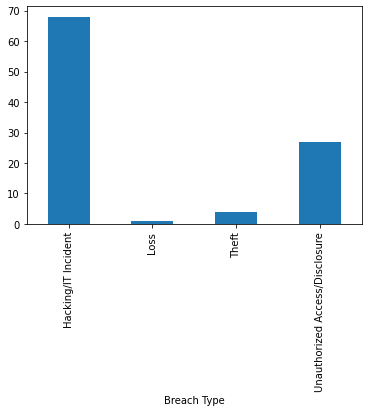

In [21]:
# plot the data
breachDist.plot(kind='bar')